In [1]:
# Necessary imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from FuzzyTM import FLSA_W
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Read the CSV file
df = pd.read_csv('What are the components of microservice (no boolean)/IEEE(Conference).csv')

In [4]:
# Preprocessing function
def preprocess_text(text):
    text = text.strip()
    # Replace URLs with empty string
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Tokenize
    words = word_tokenize(text.lower())
    # Remove non-alpha and convert to lowercase
    alpha_words = [word for word in words if word.isalpha()]
    # Remove numbers
    numbers_words = [word for word in alpha_words if not word.isdigit()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    stop_words_removed = [word for word in numbers_words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stop_words_removed]
    
    return lemmatized_words

# Combine title and abstract for analysis
df['text'] = df['Document Title'] + ' ' + df['Abstract']
df['processed_text'] = df['text'].apply(preprocess_text)

# Remove infrequent and too frequent words
# Remove infrequent and too frequent words
all_words = [word for content in df['processed_text'] for word in content]
word_freq = Counter(all_words)

min_freq = 3
max_freq = 0.7 * len(df)
filtered_words = {word for word, freq in word_freq.items() if min_freq <= freq <= max_freq}

def filter_content(content):
    return [word for word in content if word in filtered_words]

df['processed_text'] = df['processed_text'].apply(filter_content)
# Create document-term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['processed_text'].apply(lambda x: ' '.join(x)))



In [5]:
# 2. LDA
def get_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    topics = []
    for topic in model.components_:
        topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(topic_words)
    return topics

# Train LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Get LDA topics
lda_topics = get_topics(lda, vectorizer, 10)
print("\nLDA Topics:")
for idx, topic in enumerate(lda_topics):
    print(f"Topic {idx}: {' '.join(topic)}")





LDA Topics:
Topic 0: approach security model digital resource monitoring vehicle design framework management
Topic 1: development technology process business research using based model management tool
Topic 2: computing edge iot resource performance device based communication infrastructure distributed
Topic 3: approach based model framework method using anomaly development dependency analysis
Topic 4: based solution approach design framework security result resource control using


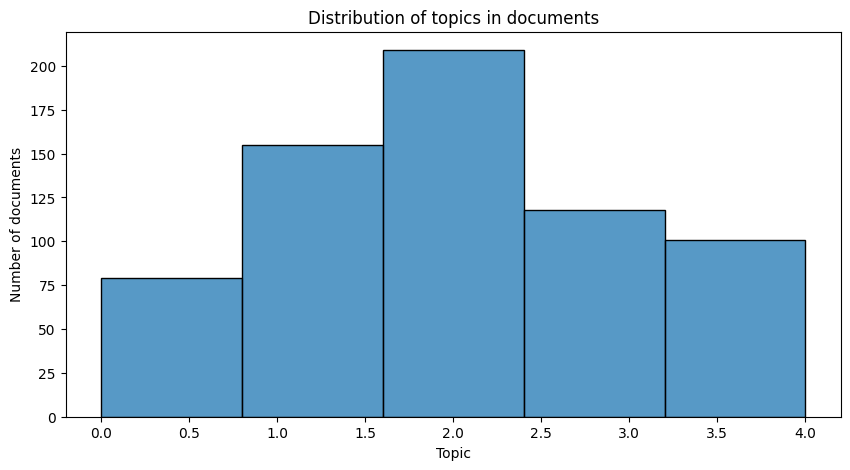

In [6]:

# Plot topic distribution
topic_dist = lda.transform(X)
dominant_topics = topic_dist.argmax(axis=1)

plt.figure(figsize=(10, 5))
sns.histplot(dominant_topics, bins=5)
plt.xlabel('Topic')
plt.ylabel('Number of documents')
plt.title('Distribution of topics in documents')
plt.show()

In [7]:
# Imports
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from umap import UMAP
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt
from FuzzyTM import FLSA_W

c:\Users\bvits\OneDrive\Desktop\2024\Uni\thesis\thesis reading\compatibility of data products\Lit Review\Processing Docs\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Combine title and abstract for analysis 
df['text'] = df['Document Title'] + ' ' + df['Abstract']
docs = df['text'].tolist()

# Create BERTopic model with parameters from example
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(
    umap_model=umap_model, 
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

# Fit model and get topics
topics, probs = topic_model.fit_transform(docs)


2025-01-23 14:32:57,937 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 21/21 [00:28<00:00,  1.36s/it]
2025-01-23 14:33:33,644 - BERTopic - Embedding - Completed ✓
2025-01-23 14:33:33,644 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-23 14:33:43,421 - BERTopic - Dimensionality - Completed ✓
2025-01-23 14:33:43,428 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-23 14:33:43,470 - BERTopic - Cluster - Completed ✓
2025-01-23 14:33:43,481 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-23 14:33:43,612 - BERTopic - Representation - Completed ✓


In [9]:
# Print topics info
print("Number of topics:", len(set(topics)))
print("\nTop terms per topic:")
print(topic_model.get_topic_info())

# Visualize topics
fig = topic_model.visualize_topics()
plt.show()


Number of topics: 8

Top terms per topic:
   Topic  Count                                               Name  \
0     -1    135                 -1_data_architecture_cloud_systems   
1      0    143                       0_edge_iot_network_computing   
2      1    141  1_microservices_architecture_software_microser...   
3      2    114       2_cloud_applications_performance_application   
4      3     39            3_security_service_attack_microservices   
5      4     38          4_digital_control_industrial_architecture   
6      5     31              5_anomaly_root_detection_microservice   
7      6     21                     6_machine_learning_models_data   

                                      Representation  \
0  [data, architecture, cloud, systems, paper, co...   
1  [edge, iot, network, computing, architecture, ...   
2  [microservices, architecture, software, micros...   
3  [cloud, applications, performance, application...   
4  [security, service, attack, microservices, t

In [11]:
# Code that obtains the articles that belong to a specific topic as a dataframe
def get_topic_articles(topic, topics, docs):
    topic_articles = []
    for idx, t in enumerate(topics):
        if t == topic:
            topic_articles.append(docs[idx])
    return pd.DataFrame(topic_articles, columns=['text'])

# Get articles for topic 2
topic_2_articles = get_topic_articles(1, topics, docs)
print("\nArticles for topic 2:")
print(topic_2_articles)






Articles for topic 2:
                                                  text
0    RapidMS: A Tool for Supporting Rapid Microserv...
1    Performance Evaluation of Monolithic and Micro...
2    A Component-Based Evolution Model for Service-...
3    Comparative Analysis of Monolith, Microservice...
4    An Approach of a Migration Process from a Lega...
..                                                 ...
136  Exploiting Paired Concepts to Facilitate Softw...
137  RESTful Web Services – A Question of Standards...
138  Pipekit: A Deployment Tool with Advanced Sched...
139  1st International Workshop on Essence in Educa...
140  YACHAY - A fully integrated system to promote ...

[141 rows x 1 columns]
